# Neuromodulation example  (bath)

This neuromodulation creates a small network of neurons. We also use the reaction diffusion model by Anu G Nair 2015.

To generate the ```reaction_diffusion.json``` file in ```data/str-dspn-e150602_c1_D1-mWT-0728MSN01-v20211026/``` from the xml file we run ```data/convert_sbml_to_json.sh```

Reference for DA modulation cascade:

Lindroos R, Dorst MC, Du K, et al. Basal Ganglia Neuromodulation Over Multiple Temporal and Structural Scales-Simulations of Direct Pathway MSNs Investigate the Fast Onset of Dopaminergic Effects and Predict the Role of Kv4.2. Front Neural Circuits. 2018;12:3. Published 2018 Feb 6. doi:10.3389/fncir.2018.00003

Here we use the data from Planert:
Planert H, Berger TK, Silberberg G. Membrane properties of striatal direct and indirect pathway neurons in mouse and rat slices and their modulation by dopamine. PLoS One. 2013;8(3):e57054. doi:10.1371/journal.pone.0057054

The neurons are held at -60mV, or -80mV, then a current injection is applied for 500ms to trigger spiking.

Figure 4:



## Network setup

We have two neurons. The first neuron (Neuron 0) receives external input (cortical from t=0s and DA from t=0.1s). The cortical input will activate the first neuron, and through activation of synapses on the second neuron, we will see the dopamine level increase in the second neuron (Neuron 1).

The first neuron also receives direct DA activation from external input (starting at 100ms).

In [1]:
import os
from snudda import Snudda

neuron_path = os.path.join("data", "dspn")
network_path = os.path.join("networks", "neuromodulation_bath_current")

In [ ]:
snudda = Snudda(network_path=network_path)
si = snudda.init_tiny(neuron_paths=neuron_path, neuron_names="dspn", number_of_neurons=[2], 
                      random_seed=123)

si.network_data["regions"]["Cube"]["neurons"]["dspn"]["reaction_diffusion"] = "data/JSON/reaction_diffusion_D1.json"

# How the ion channels are modified by DA
si.network_data["regions"]["Cube"]["neurons"]["dspn"]["modulation"] = "test-modulation.json"
si.network_data["regions"]["Cube"]["neurons"]["dspn"]["modulation_key"] = "abc"

si.write_json()

snudda.create_network()

### No synaptic input, only current injections!

In [4]:
sim_output_neuromodulation_ON = os.path.join(network_path, "simulation", "output_neuromodulation_ON.hdf5")
sim_output_neuromodulation_OFF = os.path.join(network_path, "simulation", "output_neuromodulation_OFF.hdf5")

In [ ]:
# mech_dir = os.path.join("..", "..", "..", "..", "BasalGangliaData", "data", "neurons", "mechanisms")
mech_dir = "/home/hjorth/BasalGangliaData/data/neurons/mechanisms"
sample_dt = None # 0.00005

# sim = snudda.simulate(time=0, mech_dir=mech_dir, verbose=True, sample_dt=sample_dt, output_file=sim_output_neuromodulation_ON)

In [2]:
# sim_config_on = os.path.join("data", "da_experiment_on.json")
# sim_config_off = os.path.join("data", "da_experiment_off.json")

snudda = None

sim_config_on = os.path.join("data", "da_experiment_cur_inj_on_bath.json")
sim_config_off = os.path.join("data", "da_experiment_cur_inj_off_bath.json")


sim_time = 1
n_workers = 1

## Running simulations

To see progress of the two simulations in log files ```networks/neuromodulation_ON_OFF/log/network-simulation-ON.txt``` and ```networks/neuromodulation_ON_OFF/log/network-simulation-OFF.txt```.

In [ ]:
run_str_on = f"mpirun -n {n_workers} snudda simulate {network_path} --time {sim_time} --simulation_config {sim_config_on} --mechdir {mech_dir}"
print(run_str_on)

In [ ]:
%%timeit
os.system(run_str_on)

### Rerun without neuromodulation

In [ ]:
run_str_off = f"mpirun -n {n_workers} snudda simulate {network_path} --time {sim_time} --simulation_config {sim_config_off} --mechdir {mech_dir} --disable_rxd_neuromodulation"
print(run_str_off)

In [ ]:
os.system(run_str_off)

## Load the data and plot

In [5]:
from snudda.utils import SnuddaLoadSimulation

nd = SnuddaLoadSimulation(sim_output_neuromodulation_ON)
time = nd.get_time()
data_pka = nd.get_data("PKAc", 1)[0][1]
data_da = nd.get_data("DA", 1)[0][1]
data_da_external = nd.get_data("DA", 0)[0][0]

# This is saved with add_rxd_internal_concentration_recording_all -- check that it worked 
data_pka_all0 = nd.get_data("PKAc", 0)[0][0]

Loading networks/neuromodulation_bath_current/simulation/output_neuromodulation_ON.hdf5


In [6]:
nd.list_data_types(1)

['AC5',
 'AC5GaolfGTP',
 'AC5GaolfGTP_ATP',
 'AC5_ATP',
 'AMP',
 'ATP',
 'D1R',
 'D1RDA',
 'D1RDAGolf',
 'D1RGolf',
 'DA',
 'GaolfGDP',
 'GaolfGTP',
 'Gbgolf',
 'Golf',
 'PDE10',
 'PDE10_cAMP',
 'PDE10c',
 'PDE10c_cAMP',
 'PDE4',
 'PDE4_cAMP',
 'PKA',
 'PKAc',
 'PKAcAMP2',
 'PKAcAMP4',
 'PKAc_Target1',
 'PKAreg',
 'PP1',
 'PP1_Target1p',
 'Target1',
 'Target1p',
 'cAMP',
 'kaf_ms.modulation_factor_g',
 'kaf_ms.modulation_factor_shift',
 'kir_ms.modulation_factor',
 'naf_ms.modulation_factor',
 'spikes',
 'voltage']

In [7]:
data_types = nd.list_data_types(0)
all_species_data = nd.get_all_data(neuron_id=0, exclude=["spikes", "voltage"])
time = nd.get_time()
voltage = nd.get_data("voltage", [0, 1])

In [8]:
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "iframe"  # Do not save plots in the notebook, they can get BIG

fig = go.Figure()
for data_type in all_species_data:
    fig.add_trace(go.Scatter(x=time, y=all_species_data[data_type][0][0].T[0], name=data_type))

fig.update_layout(title="With DA modulation", xaxis_title="Time (s)", yaxis_title="Concentration", width=1000, height=800)
fig.show()

In [9]:
data_types2 = nd.list_data_types(0)
all_species_data2 = nd.get_all_data(neuron_id=1, exclude=["spikes", "voltage"])
time = nd.get_time()
voltage = nd.get_data("voltage", [0, 1])

In [10]:
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "iframe"  # Do not save plots in the notebook, they can get BIG

fig = go.Figure()
for data_type in all_species_data2:
    fig.add_trace(go.Scatter(x=time, y=all_species_data2[data_type][0][1].T[0], name=data_type))

fig.update_layout(title="With DA modulation", xaxis_title="Time (s)", yaxis_title="Concentration", width=1000, height=800)
fig.show()

In [11]:
nd_off = SnuddaLoadSimulation(sim_output_neuromodulation_OFF)
time_off = nd_off.get_time()
voltage_off = nd_off.get_data("voltage", [0, 1])

Loading networks/neuromodulation_bath_current/simulation/output_neuromodulation_OFF.hdf5


In [12]:
fig = go.Figure()

sct_on = go.Scatter(x=time, y=voltage[0][0][:,0], name="DA (0.3-1.3s)", opacity=0.5)
sct_off = go.Scatter(x=time_off, y=voltage_off[0][0][:,0], name="No DA", opacity=0.5)
fig.add_traces([sct_on, sct_off])
fig.write_image("example-trace.png", scale=2, height=800, width=1200)
fig.show()

In [13]:
fig = go.Figure()

sct_on = go.Scatter(x=time, y=voltage[0][1][:,0], name="DA (0.3-1.3s)", opacity=0.5)
sct_off = go.Scatter(x=time_off, y=voltage_off[0][1][:,0], name="No DA", opacity=0.5)
fig.add_traces([sct_on, sct_off])

## Plotting simulation with DA modulation 

DA is active from 0.3 to 1.3 seconds

Loading network info from networks/neuromodulation_bath_current/network-synapses.hdf5
Loading networks/neuromodulation_bath_current/simulation/output_neuromodulation_ON.hdf5
Plotting traces: [0, 1]
Plotted 2 traces (total 2)
Saving to figure /home/hjorth/HBP/Snudda/examples/notebooks/neuromodulation/networks/neuromodulation_bath_current/figures/Network-voltage-trace--dspn-0-1.pdf


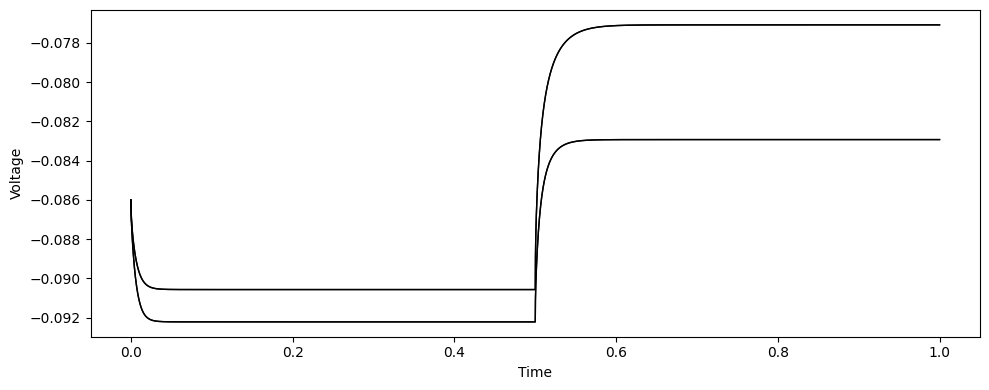

In [14]:
%matplotlib inline

from snudda.plotting.plot_traces import PlotTraces
pt = PlotTraces(output_file=sim_output_neuromodulation_ON)
# Use trace_id to specify which traces
ax = pt.plot_traces(offset=0, time_range=None,fig_size=(10,4))

## Plot simulation, with neuromodulation disabled

Loading network info from networks/neuromodulation_bath_current/network-synapses.hdf5
Loading networks/neuromodulation_bath_current/simulation/output_neuromodulation_OFF.hdf5
Plotting traces: [0, 1]
Plotted 2 traces (total 2)
Saving to figure /home/hjorth/HBP/Snudda/examples/notebooks/neuromodulation/networks/neuromodulation_bath_current/figures/Network-voltage-trace--dspn-0-1.pdf


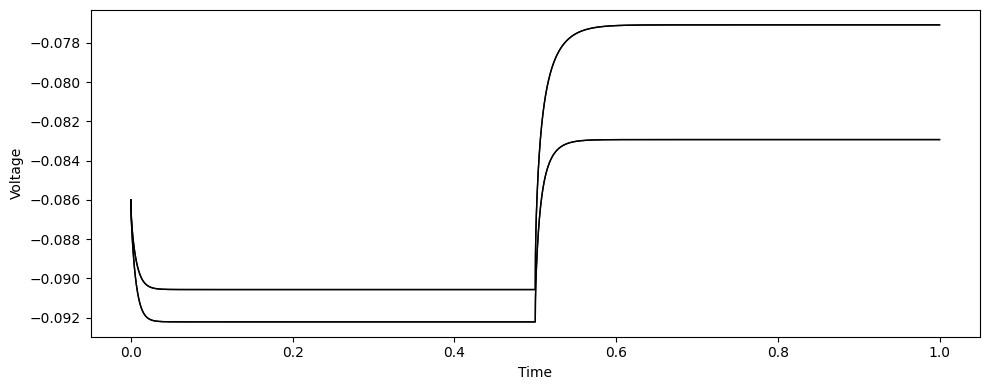

In [15]:
%matplotlib inline

from snudda.plotting.plot_traces import PlotTraces
pt_off = PlotTraces(output_file=sim_output_neuromodulation_OFF)
# Use trace_id to specify which traces
ax_off = pt_off.plot_traces(offset=0, time_range=None,fig_size=(10,4))